Based on the addresses determined to be relevant for the PCIe block in the previous notebook, the reference values are extracted from the dumped image and an autocorrelation is perfomed. In this way, all similar blocks (e.g. a second PCIe hard IP) with a similar configuration should be found.

In [1]:
import sys
import os

import numpy as np
import matplotlib.pyplot as plt

sys.path.append("../extract_pin_addr")
from JicBitstream import JicBitstream, JicBitstreamZip

%matplotlib notebook

In [2]:
array = np.array

PCIE_PARAMETER_LOCS = \
{'vendor_id': array([948937, 948969, 949001, 949033, 949065, 949097, 949129, 949161,
        949193, 949225, 949257, 949289, 949321, 949353, 949385, 949417]),
 'device_id': array([948425, 948457, 948489, 948521, 948553, 948585, 948617, 948649,
        948681, 948713, 948745, 948777, 948809, 948841, 948873, 948905]),
 'class_code': array([947657, 947689, 947721, 947753, 947785, 947817, 947849, 947881,
        947913, 947945, 947977, 948009, 948041, 948073, 948105, 948137]),
 'subsystem_device_id': array([946313, 946345, 946377, 946409, 946441, 946473, 946505, 946537,
        946569, 946601, 946633, 946665, 946697, 946729]),
 'subsystem_vendor_id': array([946889, 946921, 946953, 946985, 947017, 947049, 947081, 947113,
        947145, 947177, 947209, 947241, 947273, 947305, 947337, 947369]),
 'bar0_size_mask': array([936137, 936169, 936201, 936233, 936265, 936297, 936329, 936361,
        936393, 936425, 936457, 936489, 936521, 936553, 936585, 936617]),
 'bar2_size_mask': array([933961, 933993, 934025, 934057, 934089, 934121, 934153, 934185,
        934217, 934249, 934281, 934313, 934345, 934377, 934409, 934441])}

In [3]:
jic = JicBitstream("../bitstream_analysis/factory_decompress.jic")

In [4]:
print(jic.get_els(PCIE_PARAMETER_LOCS['vendor_id']))
print(jic.get_els(PCIE_PARAMETER_LOCS['device_id']))
print(jic.get_els(PCIE_PARAMETER_LOCS['class_code']))
print(jic.get_els(PCIE_PARAMETER_LOCS['subsystem_device_id']))
print(jic.get_els(PCIE_PARAMETER_LOCS['subsystem_vendor_id']))
print(jic.get_els(PCIE_PARAMETER_LOCS['bar0_size_mask']))
print(jic.get_els(PCIE_PARAMETER_LOCS['bar2_size_mask']))

[0 0 0 1 0 1 0 0 0 0 0 1 0 1 0 0]
[1 0 1 1 0 0 0 1 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0]
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


In [5]:
all_pcie_feat_addrs = set()

for pcie_param in PCIE_PARAMETER_LOCS.values():
    for addr in pcie_param:
        all_pcie_feat_addrs.add(addr)
        
all_pcie_feat_addrs = np.array(sorted(all_pcie_feat_addrs))
print(np.diff(all_pcie_feat_addrs))

[  32   32   32   32   32   32   32   32   32   32   32   32   32   32
   32 1696   32   32   32   32   32   32   32   32   32   32   32   32
   32   32   32 9696   32   32   32   32   32   32   32   32   32   32
   32   32   32  160   32   32   32   32   32   32   32   32   32   32
   32   32   32   32   32  288   32   32   32   32   32   32   32   32
   32   32   32   32   32   32   32  288   32   32   32   32   32   32
   32   32   32   32   32   32   32   32   32   32   32   32   32   32
   32   32   32   32   32   32   32   32   32   32   32]


In [6]:
ref_pcie_bits = jic.get_els(all_pcie_feat_addrs)
print(ref_pcie_bits)

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 1 0 1 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 1 0 1 0 0]


In [7]:
rel_feat_addrs = all_pcie_feat_addrs - all_pcie_feat_addrs[0]
print(len(rel_feat_addrs))

110


In [8]:
l = len(jic.jic)

NR_DIAG_PRINTS = 10
CORR_THRESHOLD = 102

pcie_blk_addrs = []

for i in range(l - np.max(rel_feat_addrs)):
    bits = jic.get_els(rel_feat_addrs + i)
    s = np.sum(bits == ref_pcie_bits)

    if s > CORR_THRESHOLD:
        print(f"found: addr = {i}, corr val = {s}, bits = \n{bits}")
        pcie_blk_addrs.append(i)
    if i != 0 and i % (l // NR_DIAG_PRINTS) == 0:
        print(f"progress: {i / (l // NR_DIAG_PRINTS) * NR_DIAG_PRINTS }%")

print("done")

found: addr = 933945, corr val = 109, bits = 
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 1 0 1 1 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 1 0 1 0 0 0 0 0 1 0 1 0 0]
found: addr = 933961, corr val = 110, bits = 
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 1 0 1 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 1 0 1 0 0]
progress: 10.0%
progress: 20.0%
progress: 30.0%
progress: 40.0%
progress: 50.0%
progress: 60.0%
progress: 70.0%
progress: 80.0%
progress: 90.0%
done


In [9]:
corr = []

pcie_blk_addrs = [933945, 933961]
x_min = np.min(pcie_blk_addrs) - 1000
x_max = np.max(pcie_blk_addrs) + 1000
x_roi = np.arange(x_min, x_max)

for addr in x_roi:
    bits = jic.get_els(rel_feat_addrs + addr)
    s = np.sum(bits == ref_pcie_bits)
    corr.append(s)

corr = np.array(corr)

<IPython.core.display.Javascript object>


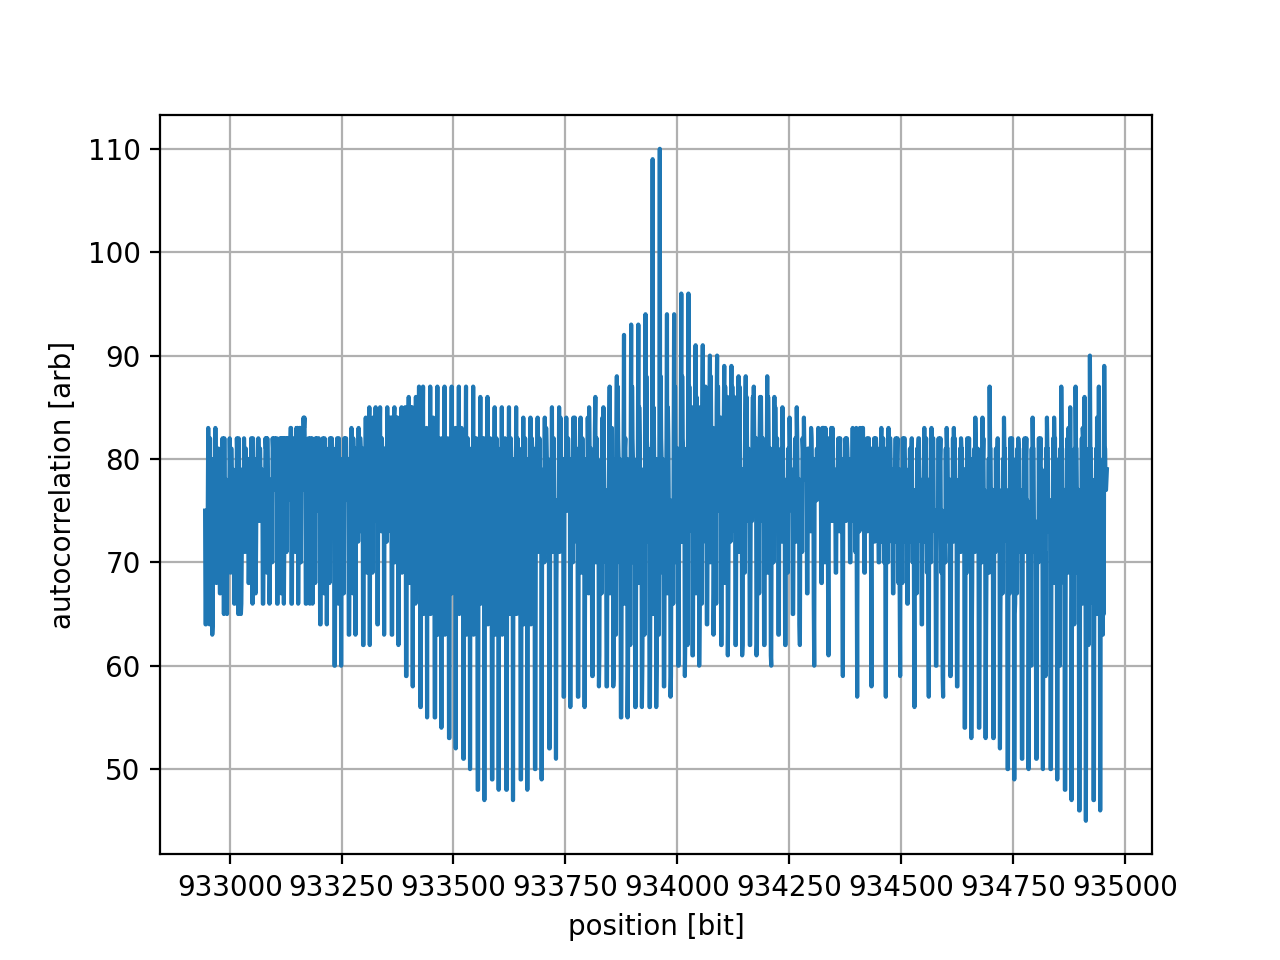

In [11]:
fig = plt.figure()
ax = fig.subplots()

ax.plot(x_roi, corr)
ax.set_xlabel("position [bit]")
ax.set_ylabel("autocorrelation [arb]")
ax.grid(True)

None